## Web server interface at https://xxxx:7473

#### Update - since the videos were filmed, neo4j requires a longer, more complex password, so the newest password is here:

**Username: neo4j**

**Password: ucb_mids_w205**

The above web server allows and interactive GUI which can output graphs visually in addition to table like output.  The nodes in the graphs can be moved around with the mouse to make the graphs more readable.


#### Basics:

```:server connect``` - connect to the server, username is "neo4j", password is "ucb_mids_w205"


```:server status``` - shows that username and server you are logged into


```:clear``` - clears off old cells


```show databases``` - note that community edition only has 1 application database that we can use neo4j, we cannot create now use other databases, we have to wipe out neo4j database for each new graph


## In the Neo4j GUI, run the following query with graph output and rearrange the nodes with your mouse if necessary:

```match (n) return n```

In [1]:
import neo4j

import pandas as pd

from IPython.display import display

## Connect, login, create driver, create session; with community edition, we can only use 1 database, the "neo4j" database


In [2]:
driver = neo4j.GraphDatabase.driver(uri="neo4j://neo4j:7687", auth=("neo4j","ucb_mids_w205"))

In [3]:
session = driver.session(database="neo4j")

## my_neo4j_wipe_out_database() - since community edition can only have 1 database "neo4j", this function will wipe out all the nodes and relationships

In [4]:
def my_neo4j_wipe_out_database():
    "wipe out database by deleting all nodes and relationships"
    
    query = "match (node)-[relationship]->() delete node, relationship"
    session.run(query)
    
    query = "match (node) delete node"
    session.run(query)

## my_neo4j_run_query_pandas() will run a Cypher query and put the results in a Pandas dataframe; easy to see how you can use Python to manipulate the returned data

In [5]:
def my_neo4j_run_query_pandas(query, **kwargs):
    "run a query and return the results in a pandas dataframe"
    
    result = session.run(query, **kwargs)
    
    df = pd.DataFrame([r.values() for r in result], columns=result.keys())
    
    return df

## my_neo4j_nodes_relationships() will print the nodes (assumes a name property) and relationships

In [6]:
def my_neo4j_nodes_relationships():
    "print all the nodes and relationships"
   
    print("-------------------------")
    print("  Nodes:")
    print("-------------------------")
    
    query = """
        match (n) 
        return n.name as node_name, labels(n) as labels
        order by n.name
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_nodes = df.shape[0]
    
    display(df)
    
    print("-------------------------")
    print("  Relationships:")
    print("-------------------------")
    
    query = """
        match (n1)-[r]->(n2) 
        return n1.name as node_name_1, labels(n1) as node_1_labels, 
            type(r) as relationship_type, n2.name as node_name_2, labels(n2) as node_2_labels
        order by node_name_1, node_name_2
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_relationships = df.shape[0]
    
    display(df)
    
    density = (2 * number_relationships) / (number_nodes * (number_nodes - 1))
    
    print("-------------------------")
    print("  Density:", f'{density:.1f}')
    print("-------------------------")
    

## Load CSV

In [7]:
df = pd.read_csv("NASDAQ_100_Data_From_2010.csv", sep='\t', parse_dates=["Date"])


In [8]:
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,Name
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.562591,493729600,AAPL
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.573935,601904800,AAPL
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.469369,552160000,AAPL
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.457407,477131200,AAPL
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.500339,447610800,AAPL
5,2010-01-11,7.600000,7.607143,7.444643,7.503929,6.442997,462229600,AAPL
6,2010-01-12,7.471071,7.491786,7.372143,7.418571,6.369709,594459600,AAPL
7,2010-01-13,7.423929,7.533214,7.289286,7.523214,6.459555,605892000,AAPL
8,2010-01-14,7.503929,7.516429,7.465000,7.479643,6.422143,432894000,AAPL
9,2010-01-15,7.533214,7.557143,7.352500,7.354643,6.314816,594067600,AAPL


In [9]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Name'], dtype='object')

High Volatility Stock Graph

In [10]:
df['return'] = df.groupby("Name")['Close'].pct_change()
volatility = df.groupby('Name')['return'].std()

In [11]:
# Create nodes
my_neo4j_wipe_out_database()

In [12]:
for stock, vol in volatility.items():
    session.run("CREATE (:Stock {ticker: $ticker, volatility: $vol})", ticker=stock, vol=vol)

# Create edges between similarly volatile stocks
threshold = 0.01
for stock1 in volatility.index:
    for stock2 in volatility.index:
        if stock1 < stock2:  # prevent duplicates
            diff = abs(volatility[stock1] - volatility[stock2])
            if diff < threshold:
                session.run("""
                    MATCH (a:Stock {ticker: $s1}), (b:Stock {ticker: $s2})
                    CREATE (a)-[:SIMILAR_VOLATILITY {diff: $diff}]->(b)
                """, s1=stock1, s2=stock2, diff=diff)

In [13]:
query = "CALL gds.graph.drop('volatility_graph', false) YIELD graphName"
my_neo4j_run_query_pandas(query)

query = """
CALL gds.graph.project(
    'volatility_graph',
    {
        Stock: {
            properties: ['volatility']
        }
    },
    {
        SIMILAR_VOLATILITY: {
            properties: ['diff']
        }
    }
)
"""
my_neo4j_run_query_pandas(query)


,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'Stock': {'label': 'Stock', 'properties': {'v...",{'SIMILAR_VOLATILITY': {'orientation': 'NATURA...,volatility_graph,102,3670,4530


In [19]:
query = """
CALL gds.knn.stream('volatility_graph', {
    topK: 10,
    nodeProperties: [
        {volatility: 'EUCLIDEAN'}
    ],
    randomSeed: 42,
    concurrency: 1,
    sampleRate: 1.0,
    deltaThreshold: 0.0
})
YIELD node1, node2, similarity
RETURN 
    gds.util.asNode(node1).ticker AS stock1, 
    gds.util.asNode(node2).ticker AS stock2, 
    similarity
ORDER BY similarity DESC
"""
knn_results = my_neo4j_run_query_pandas(query)
display(knn_results.head(10))

,stock1,stock2,similarity
0,ADI,INTC,0.999996
1,INTC,ADI,0.999996
2,AEP,COST,0.999995
3,COST,AEP,0.999995
4,MTCH,WDAY,0.999993
5,WDAY,MTCH,0.999993
6,ADP,VRSK,0.999988
7,VRSK,ADP,0.999988
8,FB,LRCX,0.999988
9,LRCX,FB,0.999988


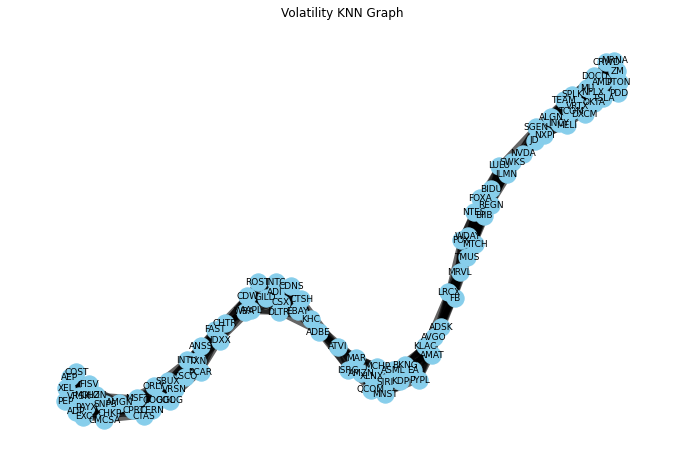

In [20]:
import networkx as nx
import matplotlib.pyplot as plt
    
# Build the graph from the KNN results
G = nx.Graph()
for _, row in knn_results.iterrows():
    G.add_edge(row['stock1'], row['stock2'], weight=row['similarity'])

# Define position layout
pos = nx.spring_layout(G, seed=42)  # consistent layout

# Draw nodes
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_size=300, node_color='skyblue')

# Draw edges with varying thickness
edges = G.edges(data=True)
nx.draw_networkx_edges(
    G, pos, edgelist=edges,
    width=[d['weight'] * 5 for (_, _, d) in edges],
    alpha=0.6
)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=9)

plt.title("Volatility KNN Graph")
plt.axis("off")
plt.show()

In [21]:
import matplotlib.pyplot as plt

In [22]:
query = """
CALL gds.louvain.write('volatility_graph', {
  writeProperty: 'community'
})
YIELD communityCount, modularity
RETURN communityCount, modularity
"""
louvain_result = my_neo4j_run_query_pandas(query)

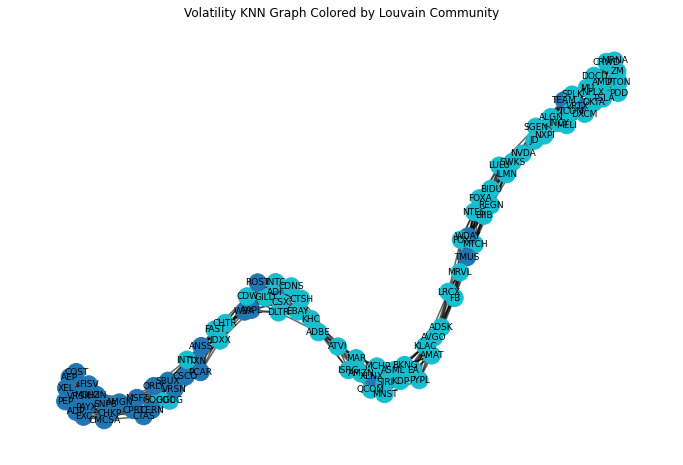

In [23]:
# Get community info (assuming you've written it to the nodes)
query = "MATCH (s:Stock) RETURN s.ticker AS ticker, s.community AS community"
communities_df = my_neo4j_run_query_pandas(query)

# Build color map
color_map = {}
unique_communities = communities_df['community'].unique()
colors = plt.cm.get_cmap('tab10', len(unique_communities))

for i, comm in enumerate(unique_communities):
    color_map[comm] = colors(i)

node_colors = [
    color_map[communities_df.set_index('ticker').loc[node]['community']]
    for node in G.nodes
]

# Re-plot with community coloring
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=300)
nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=9)
plt.title("Volatility KNN Graph Colored by Louvain Community")
plt.axis("off")
plt.show()

Number of clusters:

In [24]:
query = """
CALL gds.louvain.write('volatility_graph', {
  writeProperty: 'community'
})
YIELD communityCount, modularity
RETURN communityCount, modularity
"""

my_neo4j_run_query_pandas(query)

,communityCount,modularity
0,2,-0.001435


In [25]:
query = """
MATCH (s:Stock)
RETURN s.community AS community, count(*) AS size
ORDER BY size DESC
"""

my_neo4j_run_query_pandas(query)

,community,size
0,101,67
1,100,35


<AxesSubplot:title={'center':'Stocks per Cluster'}, xlabel='Community'>

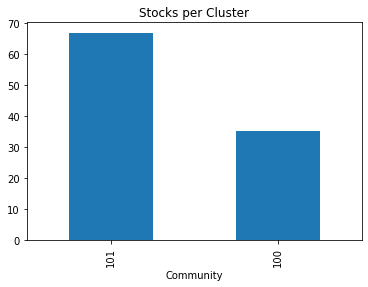

In [26]:
query = "MATCH (s:Stock) RETURN s.community AS community"
communities_df = my_neo4j_run_query_pandas(query)
communities_df['community'] = communities_df['community'].astype(str)

bar_data = communities_df['community'].value_counts().reset_index()
bar_data.columns = ['Community', 'Size']

bar_data.plot(kind='bar', x='Community', y='Size', legend=False, title='Stocks per Cluster')

Fine-tune the clustering parameters

In [27]:
thresholds = [0.005, 0.01, 0.02]
results = []

for t in thresholds:
    # 1. Wipe database
    my_neo4j_wipe_out_database()

    # 2. Create nodes
    for stock, vol in volatility.items():
        session.run("CREATE (:Stock {ticker: $ticker, volatility: $vol})", ticker=stock, vol=vol)

    # 3. Create edges using current threshold
    for stock1 in volatility.index:
        for stock2 in volatility.index:
            if stock1 < stock2:
                diff = abs(volatility[stock1] - volatility[stock2])
                if diff < t:
                    session.run("""
                        MATCH (a:Stock {ticker: $s1}), (b:Stock {ticker: $s2})
                        CREATE (a)-[:SIMILAR_VOLATILITY {diff: $diff}]->(b)
                    """, s1=stock1, s2=stock2, diff=diff)

    # 4. Project + Run Louvain
    my_neo4j_run_query_pandas("CALL gds.graph.drop('vol_graph', false) YIELD graphName")

    my_neo4j_run_query_pandas("""
    CALL gds.graph.project(
        'vol_graph',
        'Stock',
        'SIMILAR_VOLATILITY',
        { relationshipProperties: 'diff' }
    )
    """)

    result = my_neo4j_run_query_pandas("""
    CALL gds.louvain.write('vol_graph', {
        writeProperty: 'community'
    })
    YIELD communityCount, modularity
    """)

    results.append({
        'threshold': t,
        'communityCount': result.loc[0, 'communityCount'],
        'modularity': result.loc[0, 'modularity']
    })

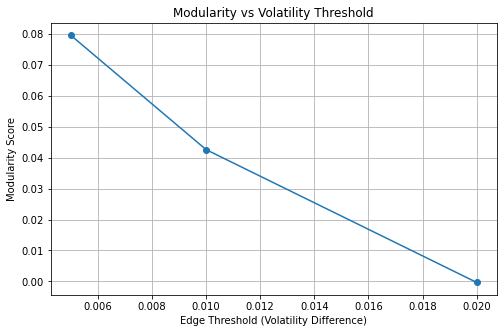

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

results_df = pd.DataFrame(results)

plt.figure(figsize=(8, 5))
plt.plot(results_df['threshold'], results_df['modularity'], marker='o')
plt.xlabel('Edge Threshold (Volatility Difference)')
plt.ylabel('Modularity Score')
plt.title('Modularity vs Volatility Threshold')
plt.grid(True)
plt.show()

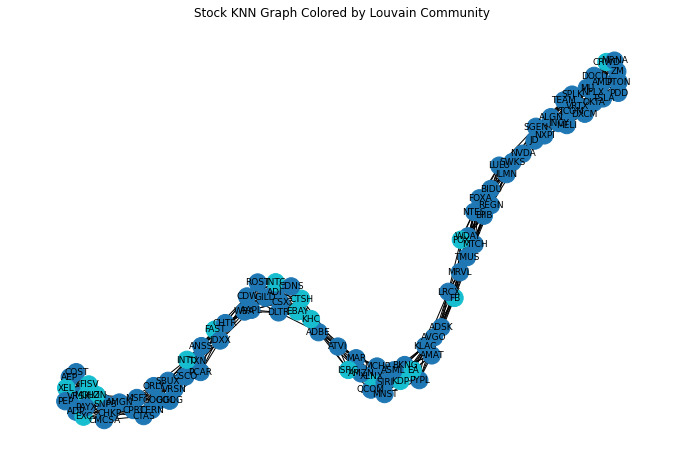

In [29]:
# Get cluster data
query = "MATCH (s:Stock) RETURN s.ticker AS ticker, s.community AS community"
comm_df = my_neo4j_run_query_pandas(query)

# Create a dictionary: {ticker -> community}
community_map = dict(zip(comm_df['ticker'], comm_df['community']))

# Assign node colors by community
unique_communities = sorted(comm_df['community'].unique())
color_palette = plt.cm.get_cmap('tab10', len(unique_communities))
node_colors = [
    color_palette(community_map[n] % 10) if n in community_map else (0.5, 0.5, 0.5)
    for n in G.nodes
]

# Re-draw graph
plt.figure(figsize=(12, 8))
nx.draw_networkx(
    G, pos,
    node_color=node_colors,
    with_labels=True,
    node_size=300,
    font_size=9
)
plt.title("Stock KNN Graph Colored by Louvain Community")
plt.axis("off")
plt.show()


In [30]:
results_df

,threshold,communityCount,modularity
0,0.005,6,0.079608
1,0.010,2,0.042617
2,0.020,3,-0.000361


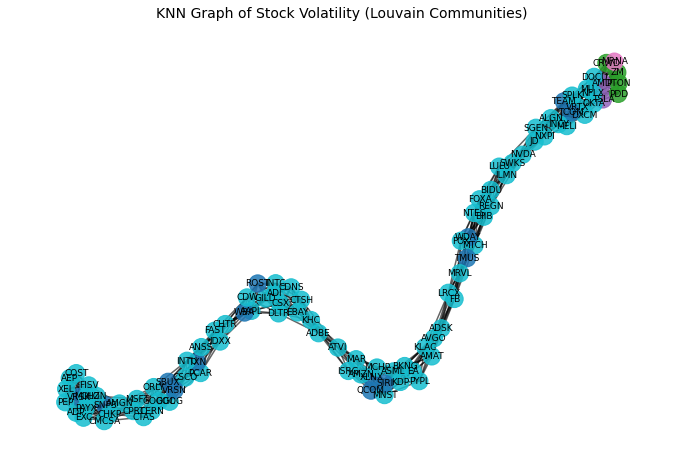

In [31]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# === Step 1: Wipe graph and rebuild with optimal threshold ===
threshold = 0.005

my_neo4j_wipe_out_database()

# Recreate nodes
for stock, vol in volatility.items():
    session.run("CREATE (:Stock {ticker: $ticker, volatility: $vol})", ticker=stock, vol=vol)

# Recreate edges
for stock1 in volatility.index:
    for stock2 in volatility.index:
        if stock1 < stock2:
            diff = abs(volatility[stock1] - volatility[stock2])
            if diff < threshold:
                session.run("""
                    MATCH (a:Stock {ticker: $s1}), (b:Stock {ticker: $s2})
                    CREATE (a)-[:SIMILAR_VOLATILITY {diff: $diff}]->(b)
                """, s1=stock1, s2=stock2, diff=diff)

# === Step 2: Reproject the graph ===
try:
    my_neo4j_run_query_pandas("CALL gds.graph.drop('volatility_graph', false) YIELD graphName")
except:
    pass

my_neo4j_run_query_pandas("""
CALL gds.graph.project(
    'volatility_graph',
    {
        Stock: {
            properties: ['volatility']
        }
    },
    {
        SIMILAR_VOLATILITY: {
            properties: ['diff']
        }
    }
)
""")

# === Step 3: Run KNN ===
knn_results = my_neo4j_run_query_pandas("""
CALL gds.knn.stream('volatility_graph', {
    topK: 10,
    nodeProperties: [
        {volatility: 'EUCLIDEAN'}
    ],
    randomSeed: 42,
    concurrency: 1,
    sampleRate: 1.0,
    deltaThreshold: 0.0
})
YIELD node1, node2, similarity
RETURN 
    gds.util.asNode(node1).ticker AS stock1, 
    gds.util.asNode(node2).ticker AS stock2, 
    similarity
ORDER BY similarity DESC
""")

# === Step 4: Run Louvain for community detection ===
my_neo4j_run_query_pandas("""
CALL gds.louvain.write('volatility_graph', {
  writeProperty: 'community'
})
YIELD communityCount, modularity
""")

# === Step 5: Pull graph and cluster info from Neo4j ===
query = "MATCH (s:Stock) RETURN s.ticker AS ticker, s.community AS community"
communities_df = my_neo4j_run_query_pandas(query)
community_map = dict(zip(communities_df['ticker'], communities_df['community']))

# === Step 6: Build NetworkX graph ===
G = nx.Graph()
for _, row in knn_results.iterrows():
    G.add_edge(row['stock1'], row['stock2'], weight=row['similarity'])

# Assign community colors
unique_comms = sorted(communities_df['community'].unique())
color_map = plt.cm.get_cmap('tab10', len(unique_comms))
node_colors = [
    color_map(community_map.get(n, -1) % 10) for n in G.nodes
]

# Layout and plot
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=300, alpha=0.85)
nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=9)
plt.title("KNN Graph of Stock Volatility (Louvain Communities)", fontsize=14)
plt.axis("off")
plt.show()


In [32]:
query = """
MATCH (s:Stock)
RETURN s.community AS community, s.ticker AS ticker
ORDER BY community, ticker
"""
cluster_members_df = my_neo4j_run_query_pandas(query)


In [33]:
from IPython.display import display

grouped = cluster_members_df.groupby('community')['ticker'].apply(list).reset_index()
grouped.columns = ['Community', 'Stocks']

# Display top few clusters
display(grouped.head())


,Community,Stocks
0,63,[MRNA]
1,92,"[AMD, TSLA]"
2,96,"[ADSK, ALGN, AMAT, AVGO, BIDU, BIIB, DOCU, DXC..."
3,99,"[AAPL, ADBE, ADI, ADP, AEP, AMGN, AMZN, ANSS, ..."
4,100,"[QCOM, ROST, SBUX, SIRI, SNPS, TCOM, TEAM, TMU..."


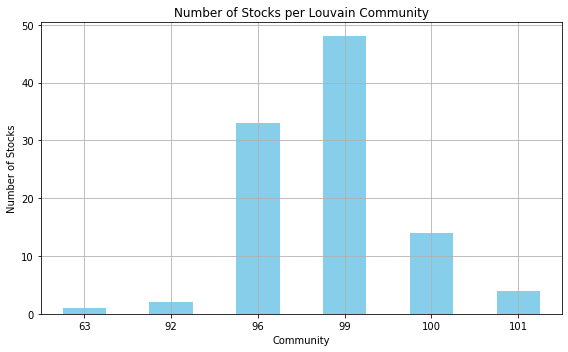

In [34]:
import matplotlib.pyplot as plt

cluster_sizes = cluster_members_df['community'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
cluster_sizes.plot(kind='bar', color='skyblue')
plt.xlabel('Community')
plt.ylabel('Number of Stocks')
plt.title('Number of Stocks per Louvain Community')
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
# Get full list of stocks per community
query = """
MATCH (s:Stock)
RETURN s.community AS community, s.ticker AS ticker
ORDER BY community, ticker
"""
cluster_members_df = my_neo4j_run_query_pandas(query)

# Group and take top 5 tickers per cluster
top_5_df = (
    cluster_members_df
    .groupby('community')['ticker']
    .apply(lambda tickers: ', '.join(tickers[:5]))
    .reset_index()
)

top_5_df.columns = ['Community', 'Top 5 Stocks']
display(top_5_df)


,Community,Top 5 Stocks
0,63,MRNA
1,92,"AMD, TSLA"
2,96,"ADSK, ALGN, AMAT, AVGO, BIDU"
3,99,"AAPL, ADBE, ADI, ADP, AEP"
4,100,"QCOM, ROST, SBUX, SIRI, SNPS"
5,101,"CRWD, PDD, PTON, ZM"


In [42]:
# Get community assignments from Neo4j
query = """
MATCH (s:Stock)
RETURN s.ticker AS ticker, s.community AS community
"""
communities_df = my_neo4j_run_query_pandas(query)

# Merge with volatility
vol_df = pd.DataFrame(volatility).reset_index()
vol_df.columns = ['ticker', 'volatility']
merged_df = pd.merge(communities_df, vol_df, on='ticker')


In [43]:
# merged_df has 'community' and 'volatility' columns already
avg_vol = (
    merged_df
    .groupby('community')['volatility']
    .mean()
    .sort_values()
    .reset_index()
)
avg_vol.columns = ['community', 'avg_volatility']

def label_volatility(v):
    if v < 0.02:
        return 'Stable'
    elif v < 0.03:
        return 'Moderate'
    else:
        return 'Volatile'

avg_vol['volatility_level'] = avg_vol['avg_volatility'].apply(label_volatility)

merged_df = pd.merge(merged_df, avg_vol, on='community')

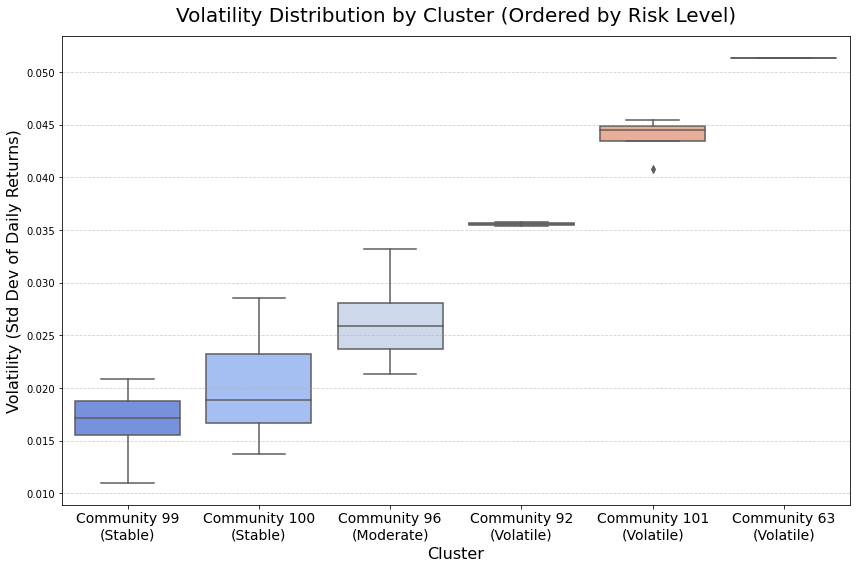

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set category order based on average volatility
ordered_communities = avg_vol['community'].tolist()

plt.figure(figsize=(12, 8))
sns.boxplot(
    data=merged_df,
    x='community',
    y='volatility',
    order=ordered_communities,
    palette='coolwarm'
)

# Label clusters with volatility level
labels = [
    f"Community {row.community}\n({row.volatility_level})"
    for _, row in avg_vol.iterrows()
]
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=0)

plt.title("Volatility Distribution by Cluster (Ordered by Risk Level)", fontsize=20, pad=15)
plt.xlabel("Cluster", fontsize=16)
plt.ylabel("Volatility (Std Dev of Daily Returns)", fontsize=16)
plt.xticks(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("boxplot_volatility_per_cluster.png", dpi=300, bbox_inches='tight')
plt.show()

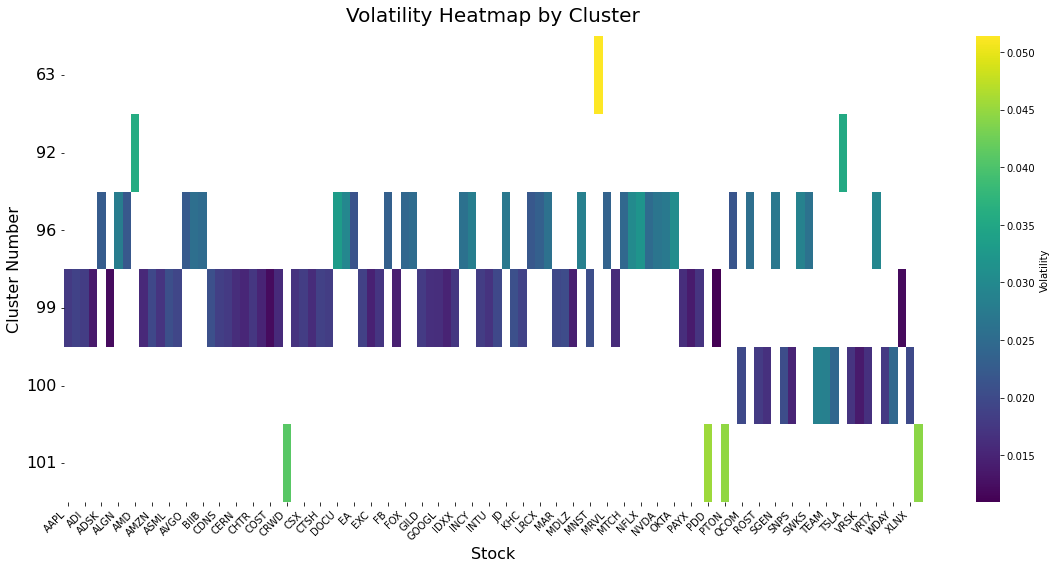

In [68]:
heatmap_df = merged_df.sort_values(by='community').pivot(index='ticker', columns='community', values='volatility')

plt.figure(figsize=(16, 8))
sns.heatmap(heatmap_df.T, cmap='viridis', cbar_kws={'label': 'Volatility'})
plt.title("Volatility Heatmap by Cluster", fontsize=20, pad=15)
plt.xlabel("Stock", fontsize=16)
plt.ylabel("Cluster Number", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=16)
plt.tight_layout()
plt.savefig("heatmap_volatility_clusters.png", dpi=300, bbox_inches='tight')
plt.show()
